In [1]:
## CNN classifier for arming the edge

In [2]:
import tensorflow as tf
import numpy as np

from glob import glob
from keras_unet.models import custom_unet
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Add, Activation, Concatenate, Flatten
from tensorflow.keras.layers import Cropping2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, Dropout, Reshape
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from PIL import Image
from random import shuffle

import matplotlib.image as mpimg
import os
  

%pylab inline

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/rjackson/.conda/envs/pydda_env/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Crop white space out of all images if not already done

In [2]:
raw_images = '/lambda_stor/data/rjackson/lidar_pngs/5min/**/*.png'
raw_img_list = glob(raw_images, recursive=True)
print(len(raw_img_list))

22605


In [14]:
for image_file in raw_img_list:
    yourImage = Image.open(image_file)
    yourImage.crop((130, 40, 1320, 410)).save(image_file)

## Augment training images for cloudy by doing a left-right flip, same for rain

In [25]:
cla = 'rain'
num_replications = 15
cloudy_data_path = '/lcrc/group/earthscience/rjackson/lidar_pngs/5min_snr/training/%s/*.png' % cla
cloud_images = glob(cloudy_data_path)
print(len(cloud_images))

606


In [26]:
train_datagen_flip = ImageDataGenerator(rescale=1/255., 
                                        horizontal_flip=True, 
                                        width_shift_range=[-5, 5])
j = 0
for image in cloud_images:
    img = load_img(image)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape) 

    i = 0
    for batch in train_datagen_flip.flow(x, batch_size=1,
                                        save_to_dir='/lcrc/group/earthscience/rjackson/lidar_pngs/augmented/%s/' % cla,
                                        save_prefix=str(j) + str(i), save_format='png'):
        i += 1
        if i >= num_replications:
            break
    
    j += 1
    if j % 100 == 0:
        print('%d/%d' % (j, len(cloud_images)))

100/606
200/606
300/606
400/606
500/606
600/606


In [ ]:
train_datagen_flip = ImageDataGenerator(rescale=1/255., 
                                        horizontal_flip=True, 
                                        brightness_range=[0.95, 1.05], width_shift_range=[-5, 5])
j = 0
fig, ax = plt.subplots(6, 6, figsize=(15, 20))
image = cloud_images[0]
img = load_img(image)
x = img_to_array(img)
x = x.reshape((1,) + x.shape) 

i = 0
j = 0
for batch in train_datagen_flip.flow(x, batch_size=1):
    ax[i, j].imshow(batch[0])
    i = i + 1
    if i >= 6:
        j = j + 1
        i = 0
    if j >= 6:
        break

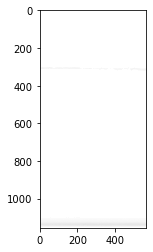

(1155, 566, 4)


In [33]:
img=mpimg.imread('/lambda_stor/data/rjackson/lidar_pngs/5min/training/cloudy/sgpdlacfC1.a1.20170924.220114.moments11.png')
imgplot = plt.imshow(img)
plt.show()
print(img.shape)
# (150, 50), (1300, 400)

In [ ]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(directory='/lcrc/group/earthscience/rjackson/lidar_pngs/5min/training',
                                                    class_mode='categorical', classes=['clear', 'cloudy', 'rain'],
                                                    target_size=(256, 128), shuffle=True, batch_size=16)
plt.imshow()

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_datagen_flip = ImageDataGenerator(rescale=1/255., horizontal_flip=True, width_shift_range=5)

In [4]:
train_generator = train_datagen.flow_from_directory(directory='/lcrc/group/earthscience/rjackson/lidar_pngs/5min_snr/training',
                                                    class_mode='categorical', classes=['clear', 'cloudy', 'rain'],
                                                    target_size=(256, 192), shuffle=True, batch_size=32)
valid_generator = train_datagen.flow_from_directory(directory='/lcrc/group/earthscience/rjackson/lidar_pngs/5min_snr/validation',
                                                    class_mode='categorical', classes=['clear', 'cloudy', 'rain'],
                                                    target_size=(256, 192), shuffle=True, batch_size=32)
train_generator_flip = train_datagen.flow_from_directory(directory='/lcrc/group/earthscience/rjackson/lidar_pngs/augmented',
                                                    class_mode='categorical', classes=['clear', 'cloudy', 'rain'],
                                                    target_size=(256, 192), batch_size=32)
#valid_generator_flip = train_datagen.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/augmented/',
#                                                    class_mode='categorical', classes=['clear', 'cloudy', 'rain'],
#                                                    target_size=(512, 128), batch_size=32)

Found 13707 images belonging to 3 classes.
Found 6617 images belonging to 3 classes.
Found 29623 images belonging to 3 classes.


In [ ]:
def resnet(IMG_HEIGHT=256, IMG_WIDTH=128):
    restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
    restnet.summary()
    output = restnet.layers[-1].output
    output = Flatten()(output)
    restnet = Model(restnet.input,output)
    for layer in restnet.layers[:-4]:
        layer.trainable = False
    model = Sequential()
    model.add(restnet)
    model.add(Dense(512, activation='relu', bias_regularizer=l2(0.01)))
    #model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu', bias_regularizer=l2(0.01)))
    #model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu', bias_regularizer=l2(0.01)))
    #model.add(Dropout(0.3))
    model.add(Dense(3, name='targets',
                    activation='softmax',
                    kernel_initializer='he_normal', bias_regularizer=l2(0.01)))
    return model

def vgg(IMG_HEIGHT=256, IMG_WIDTH=128):
    restnet = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))
    restnet.summary()
    output = restnet.layers[-1].output
    output = Flatten()(output)
    restnet = Model(restnet.input,output)
    #for layer in restnet.layers[:-4]:
    #    layer.trainable = False
    model = Sequential()
    model.add(restnet)
    model.add(restnet)
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
    #model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
    #model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
    #model.add(Dropout(0.3))
    model.add(Dense(3, name='targets',
                    activation='softmax',
                    kernel_initializer='he_normal', kernel_regularizer=l2(0.01)))
    return model

In [79]:
def conv_net_layer(inp, skip=False, num_channels=2, batch_norm=True,
                   activate=True, add_layer=None):
    x = Conv2D(num_channels, kernel_size=(2, 2), kernel_initializer='he_normal', padding='same',
              kernel_regularizer=l2(0.01))(inp)
    x = Conv2D(num_channels, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same',
              kernel_regularizer=l2(0.01))(x)
    if batch_norm:
        x = Dropout(0.3)(x)
    if activate:
        if add_layer is True:
            x = Add()([x, inp])
        x = Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)
    return x

def conv_net_layer_up(inp, skip=False, num_channels=2, batch_norm=True,
                      activate=True, add_layer=None):
    x = Conv2D(1, kernel_size=(3, 3), kernel_initializer='he_normal')(inp)
    x = Conv2D(num_channels, kernel_size=(3, 3), kernel_initializer='he_normal')(x)
    x = Conv2D(3, kernel_size=(3, 3), kernel_initializer='he_normal')(x)
    if batch_norm:
        x = Dropout(0.3)(x)
    if activate:
        if add_layer is not None:
            x = Add()([x, inp])
        x = Activation('relu')(x)
        x = UpSampling2D((2, 2))(x)
    return x

def conv_net_classifier(velocity=False):
    ref_inp = Input(shape=(256, 128, 3), name='snr')
          
    layer2 = conv_net_layer(ref_inp, num_channels=16, batch_norm=True,
             activate=True, add_layer=False)
    layer2 = conv_net_layer(layer2, num_channels=16, batch_norm=True,
             activate=True, add_layer=False)
    layer2 = conv_net_layer(layer2, num_channels=16, batch_norm=True,
             activate=True, add_layer=False)
    layer2 = conv_net_layer(layer2, num_channels=16, batch_norm=True,
             activate=True, add_layer=False)
    layer2 = conv_net_layer(layer2, num_channels=16, batch_norm=True,
             activate=True, add_layer=False)
    ref_out = conv_net_layer(layer2, num_channels=16, add_layer=False, batch_norm=True, activate=False)
    #ref_skip = Activation('relu')(ref_skip)
    #ref_out = Add()([ref_out, ref_skip])
    #ref_out = Activation('relu')(ref_out)
    if velocity:   
        x = Concatenate()([ref_out, vel_out])
    else:
        x = ref_out 
    
    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = Flatten()(x)
    #x = AveragePooling2D()(x)
    outputs = Dense(512, activation='relu',)(x)
    outputs = Dense(512, activation='relu',)(outputs)
    outputs = Dense(512, activation='relu',)(outputs)
    outputs = Dense(512, activation='relu',)(outputs)
    outputs = Dense(3, name='targets',
                    activation='softmax', activity_regularizer=l1(0.01),
                    )(outputs)

    #x = Dense(2, activation='relu')(x)
    #x = Dense(3, activation='softmax', name='label')(x)
    if velocity:
        return Model(inputs=[ref_in, vel_in], outputs=outputs)
    else:
        return Model(ref_inp, outputs)

def combine_generator(gen1, gen2):
    while True:
        yield(next(gen1), next(gen2))

In [80]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [92]:
model = vgg()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=100000,
    decay_rate=0.9)
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 256, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 64, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 64, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 64, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 32, 128)       0     

ValueError: Exception encountered when calling layer "model_19" (type Functional).

Input 0 of layer "block1_conv1" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 16384)

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 16384), dtype=float32)
  • training=None
  • mask=None

In [93]:
class_weight = {0: 1.,
                1: 2.5,
                2: 15.}
checkpointer = ModelCheckpoint(
               filepath=('/homes/rjackson/arming_the_edge/models/vgg-combined-1layer-{epoch:03d}.hdf5'),
               verbose=1)
early_stopping = EarlyStopping(restore_best_weights=True, patience=100, monitor="val_loss", mode="max")
history = model.fit(train_generator_flip, validation_data=valid_generator, epochs=2000,
          callbacks=[checkpointer, early_stopping], initial_epoch=0)

Epoch 1/2000
755/755 [==============================] - ETA: 0s - loss: 1.0953 - accuracy: 0.3761
Epoch 00001: saving model to /homes/rjackson/arming_the_edge/models/vgg-combined-1layer-001.hdf5
755/755 [==============================] - 43s 57ms/step - loss: 1.0953 - accuracy: 0.3761 - val_loss: 1.0662 - val_accuracy: 0.2785
Epoch 2/2000
755/755 [==============================] - ETA: 0s - loss: 1.0953 - accuracy: 0.3761
Epoch 00002: saving model to /homes/rjackson/arming_the_edge/models/vgg-combined-1layer-002.hdf5
755/755 [==============================] - 44s 59ms/step - loss: 1.0953 - accuracy: 0.3761 - val_loss: 1.1090 - val_accuracy: 0.2785
Epoch 3/2000
755/755 [==============================] - ETA: 0s - loss: 1.0951 - accuracy: 0.3748
Epoch 00003: saving model to /homes/rjackson/arming_the_edge/models/vgg-combined-1layer-003.hdf5
755/755 [==============================] - 43s 57ms/step - loss: 1.0951 - accuracy: 0.3748 - val_loss: 1.0868 - val_accuracy: 0.2785
Epoch 4/2000
755

KeyboardInterrupt: 

In [13]:
labels_predict = model.predict(valid_generator)
labels_train = model.predict(train_generator)

In [12]:
model = load_model('../models/resnet50-040.hdf5')

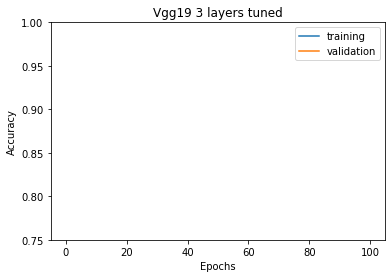

In [39]:
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.75, 1])
plt.legend()
plt.title('Vgg19 3 layers tuned')
plt.savefig('Vgg193layers.png')

Layerwise relevance propogation

In [8]:
model.layers

In [15]:
xs = []
ys = []
for i in range(10):
    x, y = valid_generator.next()
    xs.append(tf.convert_to_tensor(x))
    ys.append(tf.convert_to_tensor(y))
#x = np.stack(x)
#y = np.stack(y)

In [26]:
model.layers[-1].activation

<function tensorflow.python.keras.activations.softmax(x, axis=-1)>

In [16]:
import tensorflow.keras.backend as K

def lrp(model, x, y):
    Rn = model.layers[-1].activation(y)
    Rnp1 = 0
    # Compute activations
    A = []
    xi = x
    for L in model.layers:
        print(L)
        xi = L.apply(xi)
        if isinstance(L, tf.keras.layers.InputLayer):
            A.append(xi)
        else:
            A.append(L.activation(xi))
    
    i = len(model.layers)
    for L in model.layers[:1:-1]:
        z = np.eps + A[i].dot(L.weights)
        s = Rn / z
        c = s.dot(L.weights)
        Rn = A[i - 1] * c
        i = i - 1
    
    return Rn

In [8]:
lrp(model, xs[0], ys[0])

NameError: name 'xs' is not defined

In [7]:
classes = np.argmax(np.concatenate([labels_predict]), axis=1)

In [8]:
classes.max()

1

In [15]:
y_true = np.zeros_like(classes)
i = 0
while i < len(classes):
    if i < labels_predict.shape[0]:
        x, y = valid_generator.next()
    else:
        x, y = train_generator.next()
    y_true[i:i+y.shape[0]] = np.argmax(y, axis=1)
    i += y.shape[0]
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=classes).numpy()

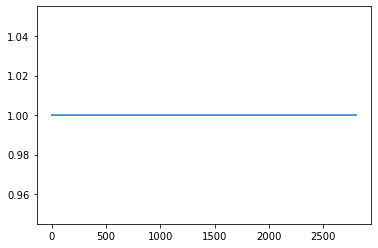

In [16]:
plt.plot(np.argmax(labels_predict, axis=1))

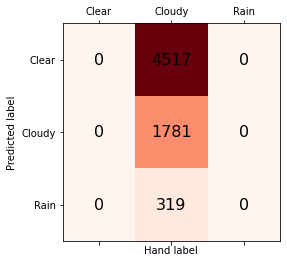

In [16]:
fig, ax = plt.subplots(1, 1)
ax.matshow(con_mat, cmap='Reds')
for (i, j), z in np.ndenumerate(con_mat):
    ax.text(j, i, '{:d}'.format(z), ha='center', va='center', color='k', fontsize=16)

ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(['Clear', 'Cloudy', 'Rain'])
ax.set_yticklabels(['Clear', 'Cloudy', 'Rain'])
ax.set_xlabel('Hand label')
ax.set_ylabel('Predicted label')
fig.savefig('confusion_matrix_1layer_resnet_augmented.png', dpi=300)

In [29]:
train_generator = train_datagen.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/5min/training',
                                                    class_mode='input', target_size=(1024, 128), shuffle=True,
                                                    batch_size=16)
valid_generator = train_datagen.flow_from_directory(directory='/lambda_stor/data/rjackson/lidar_pngs/5min/validation',
                                                    class_mode='input', 
                                                    target_size=(1024, 128), shuffle=True, batch_size=16)

FileNotFoundError: [Errno 2] No such file or directory: '/lambda_stor/data/rjackson/lidar_pngs/5min/training'

In [28]:
def conv_net_encoder():
    ref_inp = Input(shape=(1024, 128, 3), name='snr')
      
    x = Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(ref_inp)
    l1 = Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_normal',  padding='same', activation='relu')(x)
    x = BatchNormalization()(l1)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    l2 = Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal',  padding='same', activation='relu')(x)
    x = BatchNormalization()(l2)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    l3 = Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(l3)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(8, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    l4 = Conv2D(8, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(l4)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(4, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    l5 = Conv2D(4, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(l5)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(2, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    l6 = Conv2D(2, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(l6)
    encode = MaxPooling2D((2,2), name='encoding')(x)
    
    x = Conv2DTranspose(2, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(encode)
    x = Conv2DTranspose(2, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(4, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = Conv2DTranspose(4, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(8, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = Conv2DTranspose(8, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = Conv2DTranspose(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    ref_out = Conv2DTranspose(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(x)
    ref_out = Conv2DTranspose(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(ref_out)
    ref_out = BatchNormalization()(ref_out)
    ref_out = UpSampling2D((2,2))(ref_out)
    ref_out = Conv2DTranspose(64, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(ref_out)
    ref_out = Conv2DTranspose(64, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(ref_out)
    ref_out = BatchNormalization()(ref_out)
    ref_out = UpSampling2D((2,2))(ref_out)
    ref_out = Conv2DTranspose(3, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same', activation='relu')(ref_out)
    return Model(ref_inp, ref_out)

In [29]:
autoencoder = conv_net_encoder()

In [30]:
autoencoder.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
snr (InputLayer)             [(None, 1024, 128, 3)]    0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 1024, 128, 64)     1792      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 1024, 128, 64)     36928     
_________________________________________________________________
batch_normalization_50 (Batc (None, 1024, 128, 64)     256       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 512, 64, 64)       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 512, 64, 32)       18464     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 512, 64, 32)       9248

In [31]:
checkpointer = ModelCheckpoint(
               filepath=('/homes/rjackson/arming_the_edge/models/encoder-%dframes-{epoch:03d}.hdf5'),
               verbose=1)
autoencoder.fit(train_generator, validation_data=valid_generator, epochs=150, callbacks=[checkpointer], initial_epoch=0)

Epoch 1/150
696/696 [==============================] - 127s 180ms/step - loss: 0.3905 - val_loss: 0.0148

Epoch 00001: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-001.hdf5
Epoch 2/150
696/696 [==============================] - 126s 181ms/step - loss: 0.0088 - val_loss: 0.0049

Epoch 00002: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-002.hdf5
Epoch 3/150
696/696 [==============================] - 124s 179ms/step - loss: 0.0039 - val_loss: 0.0017

Epoch 00003: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-003.hdf5
Epoch 4/150
696/696 [==============================] - 125s 180ms/step - loss: 0.0068 - val_loss: 0.0038

Epoch 00004: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-004.hdf5
Epoch 5/150
696/696 [==============================] - 125s 179ms/step - loss: 0.0032 - val_loss: 0.0040

Epoch 00005: saving model to /homes/rjackson/arming_the_edge/models/encoder-%dframes-005.hdf5


KeyboardInterrupt: 

In [24]:
encoder = load_model('/homes/rjackson/arming_the_edge/models/encoder-%dframes-055.hdf5')

OSError: SavedModel file does not exist at: /homes/rjackson/arming_the_edge/models/encoder-%dframes-055.hdf5/{saved_model.pbtxt|saved_model.pb}

In [24]:
with tf.device('/device:GPU:5'):
    pics = autoencoder.predict(train_generator.next())

In [35]:
encoder = Model(autoencoder.input, autoencoder.get_layer('encoding').output)

In [85]:
with tf.device('/device:GPU:6'):
    encodings = encoder.predict(train_generator)
    encodings_validation = encoder.predict(valid_generator)

In [87]:
encodings = np.reshape(encodings, (encodings.shape[0], encodings.shape[1]*encodings.shape[2]*encodings.shape[3]))
encodings_validation = np.reshape(encodings_validation, 
                                  (encodings_validation.shape[0],
                                   encodings_validation.shape[1]*encodings_validation.shape[2]*encodings_validation.shape[3]))

In [ ]:
encodings_validation = np.reshape(encodings_validation, 
                                  (encodings_validation.shape[0],
                                   encodings_validation.shape[1]*encodings_validation.shape[2]*encodings_validation.shape[3]))

In [88]:
encodings_valid = np.squeeze(np.argwhere(np.isfinite(np.sum(encodings, axis=1))))
encodings = encodings[encodings_valid, :]
encodings_valid = np.squeeze(np.argwhere(np.isfinite(np.sum(encodings_validation, axis=1))))
encodings_validation = encodings_validation[encodings_valid, :]

In [39]:
encodings.shape

(11132, 64)

In [95]:
train_labels = np.zeros((encodings.shape[0], 3))
valid_labels = np.zeros((encodings_validation.shape[0], 3))

for i in range(0, encodings.shape[0], 16):
    x, y = train_generator.next()
    num_y = y.shape[0]
    train_labels[i:i+num_y, :] = y[:num_y, :]
    
for i in range(0, encodings_validation.shape[0], 16):
    x, y = valid_generator.next()
    num_y = y.shape[0]
    valid_labels[i:i+num_y, :] = y[:num_y, :]

In [141]:
def nn_encodings():
    ref_inp = Input(shape=(64,), name='snr')
    x = ref_inp
    for i in range(10):
        x = Dense(2048, activation='relu')(x)
        x = Dropout(0.5)(x)
    out = Dense(3, activation='softmax')(x)
    return Model(ref_inp, out)

In [142]:
nn_classifier = nn_encodings()
nn_classifier.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
nn_classifier.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
snr (InputLayer)             [(None, 64)]              0         
_________________________________________________________________
dense_102 (Dense)            (None, 2048)              133120    
_________________________________________________________________
dropout_15 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_103 (Dense)            (None, 2048)              4196352   
_________________________________________________________________
dropout_16 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_104 (Dense)            (None, 2048)              4196352   
_________________________________________________________________
dropout_17 (Dropout)         (None, 2048)              0  

In [143]:
checkpointer = ModelCheckpoint(
               filepath=('/homes/rjackson/arming_the_edge/models/classifier-encodings-{epoch:03d}.hdf5'),
               verbose=1)
nn_classifier.fit(encodings, train_labels, validation_data=(encodings_validation, valid_labels), epochs=150,
                 callbacks=[checkpointer])

Epoch 1/150
348/348 [==============================] - 3s 6ms/step - loss: 0.8497 - accuracy: 0.6895 - val_loss: 0.7815 - val_accuracy: 0.6968

Epoch 00001: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-001.hdf5
Epoch 2/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7863 - accuracy: 0.6997 - val_loss: 0.7800 - val_accuracy: 0.6968

Epoch 00002: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-002.hdf5
Epoch 3/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7711 - accuracy: 0.7078 - val_loss: 0.7796 - val_accuracy: 0.6968

Epoch 00003: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-003.hdf5
Epoch 4/150
348/348 [==============================] - 2s 5ms/step - loss: 0.7740 - accuracy: 0.6999 - val_loss: 0.7798 - val_accuracy: 0.6968

Epoch 00004: saving model to /homes/rjackson/arming_the_edge/models/classifier-encodings-004.hdf5
Epoch 5/150
348/348 [===========

In [ ]:
from sklearn.cluster import KMeans
SSE = np.zeros(20)

for i in range(1, 21):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(encodings)
    SSE[i-1] = kmeans.inertia_

Text(0, 0.5, 'Total squared error')

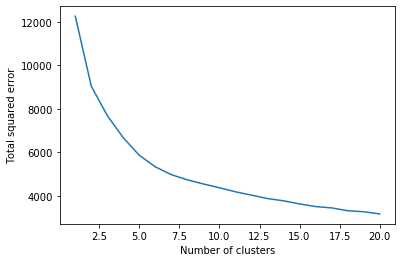

In [46]:
plt.plot(range(1, 21), SSE)
plt.xlabel('Number of clusters')
plt.ylabel('Total squared error')

In [47]:
num_classes = 5
kmeans = KMeans(n_clusters=num_classes)
kmeans.fit(encodings)
classes = kmeans.predict(encodings)

In [65]:
train_generator[1]

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [1.     

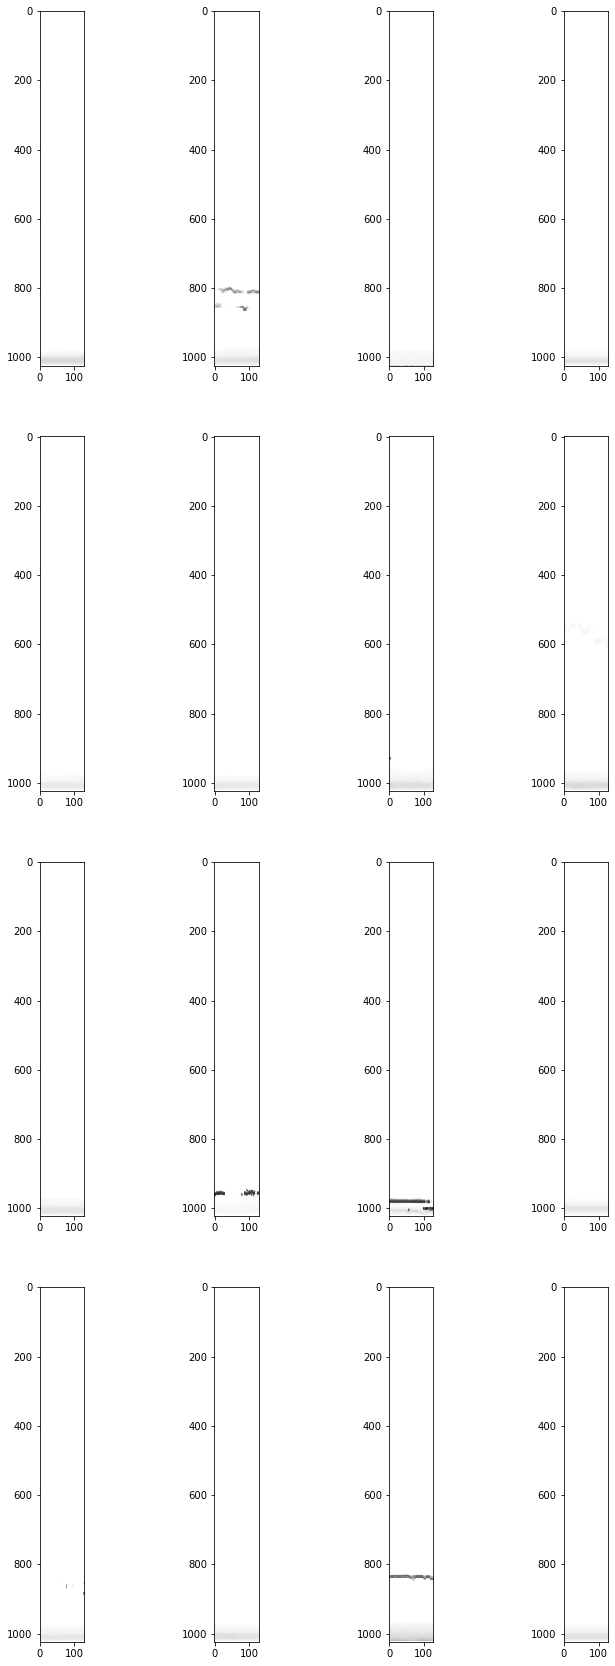

In [70]:
my_class = 2
where_class = np.argwhere(classes == my_class)
fig, ax = plt.subplots(4, 4, figsize=(12,30))
for i in range(16):
    ax[int(i / 4), i % 4].imshow(np.squeeze(train_generator[int(where_class[i] / 16)][0][where_class[i] % 16]))